In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib notebook
import seaborn as sns
import shapefile as shp
import pyproj
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import box
from shapely.geometry.polygon import Polygon
import mapclassify as mc
from scipy.spatial import distance
from scipy import ndimage
import geopandas as gpd
from shapely.geometry import shape, Point, Polygon
import csv
import os
import importlib
from pulp import *
import math
import scripts.neighbors as neigh #scripts.
importlib.reload(neigh)
import copy


In [2]:
desired_width = 320
pd.set_option('display.width', desired_width)
np.set_printoptions(linewidth=desired_width)
pd.set_option('display.max_columns', 10)

In [3]:
#locate madrid traffic data
data_path = os.getcwd()+'\\csv_files\\traffic_points.csv'
data = pd.read_csv(data_path)
raw_traffic_df = pd.DataFrame(data=data)

In [4]:
#load poi
gp_poi=shp.Reader(os.getcwd()+'\shapefiles\gis_osm_pois_free_1.shp')

In [5]:
def point_df_to_gdf(df):
    """takes a dataframe with columns named 'longitude' and 'latitude'
    to transform to a geodataframe with point features"""

    df['coordinates'] = df[['longitud', 'latitud']].values.tolist()
    df['coordinates'] = df['coordinates'].apply(Point)
    df = gpd.GeoDataFrame(df, geometry='coordinates')
    return df
    
def polygon_df_to_gdf(df):
    """takes a dataframe with columns named 'longitude' and 'latitude'
    to transform to a geodataframe with point features"""
    geometry = [box(x1, y1, x2, y2) for x1,y1,x2,y2 in zip(df.left, df.bottom, df.right, df.top)]
    df = df.drop(['left', 'bottom', 'right', 'top'], axis=1)
    geodf = gpd.GeoDataFrame(df, geometry=geometry)
    return df

def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords'
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    records = [y[:] for y in sf.records()]
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

In [6]:
traffic_points_gdf = point_df_to_gdf(raw_traffic_df)

In [7]:
traffic_points_gdf.to_file(os.getcwd()+'\\shapefiles\\traffic_points.shp')

C:\Users\User\AppData\Local\Temp\ipykernel_13940\1920669170.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  traffic_points_gdf.to_file(os.getcwd()+'\\shapefiles\\traffic_points.shp')


In [8]:
#shp_charg_stat = shp.Reader(os.getcwd()+'\\shapefiles\\charging_stations.shp')
shp_charg_stat = shp.Reader(os.getcwd()+'\\shapefiles\\EV_points.shp')
#print(shp_charg_stat.records())

In [9]:
shp_path_roads_1 = os.getcwd()+'\\shapefiles\\gis_osm_roads_free_1.shp'
sf_roads_1 = shp.Reader(shp_path_roads_1)
df_roads = read_shapefile(sf_roads_1)
df_roads['coords'] = df_roads['coords'].apply(LineString)
df_roads = gpd.GeoDataFrame(df_roads, geometry='coords')

In [10]:
df_charg_stat = read_shapefile(shp_charg_stat)
df_charg_stat['longitud']=[df_charg_stat['coords'][i][0][0] for i in range(len(df_charg_stat))]
df_charg_stat['latitud']=[df_charg_stat['coords'][i][0][1] for i in range(len(df_charg_stat))]
drop_columns = ['coords']
df_charg_stat = df_charg_stat.drop(labels=drop_columns, axis=1)

In [11]:
existing_chargers_gdf = point_df_to_gdf(df_charg_stat)
existing_chargers_gdf.to_file(os.getcwd()+'\\shapefiles\\existing_chargers.shp')

C:\Users\User\AppData\Local\Temp\ipykernel_13940\2352914606.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  existing_chargers_gdf.to_file(os.getcwd()+'\\shapefiles\\existing_chargers.shp')


In [12]:
# Convert poi
poi_df = read_shapefile(gp_poi)
poi_df['longitud']=[poi_df['coords'][i][0][0] for i in range(len(poi_df))]
poi_df['latitud']=[poi_df['coords'][i][0][1] for i in range(len(poi_df))]
poi_gdf = point_df_to_gdf(poi_df)

In [13]:
y_lim = (40.3,40.58)                                    # y coordinates (boundaries of city of Manchester)
x_lim = (-3.85,-3.55)                                    # x coordinates (boundaries of city of Manchester)
x1_y1 = (-2.2648971967997866,53.437999025519474)             # latitudes (boundaries of city of Manchester)
x2_y2 = (-2.1597774081293526,53.5055991531199)            # longitudes (boundaries of city of Manchester)

In [14]:
rect=Polygon([(x_lim[0],y_lim[0]),(x_lim[0],y_lim[1]),(x_lim[1],y_lim[1]),(x_lim[1],y_lim[0]),(x_lim[0],y_lim[0])])
rect_gdf=gpd.GeoDataFrame([1], geometry = [rect], crs=27700)

In [15]:
traffic_points_clip=traffic_points_gdf.clip(rect)
traffic_points_clip.to_file(os.getcwd()+'\\shapefiles\\traffic_points_clip.shp')

C:\Users\User\AppData\Local\Temp\ipykernel_13940\2530361015.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  traffic_points_clip.to_file(os.getcwd()+'\\shapefiles\\traffic_points_clip.shp')


In [16]:
gdf_roads_clip=df_roads.clip(rect)
#drop_columns = ['coords']
#gdf_roads_clip = gdf_roads_clip.drop(labels=drop_columns, axis=1)
gdf_roads_clip.to_file(os.getcwd()+'\\shapefiles\\map.shp')

(40.3, 40.58)

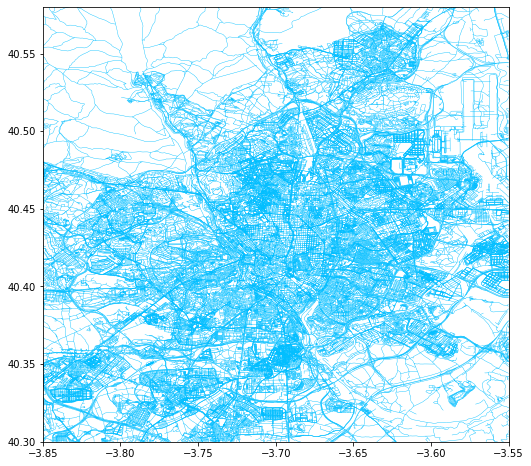

In [17]:
base = gdf_roads_clip.plot(figsize=(12, 8), color='deepskyblue', lw=0.4, zorder=0)  # Zorder controls the layering of the charts with
base.set_xlim(x_lim)
base.set_ylim(y_lim)

<AxesSubplot:>

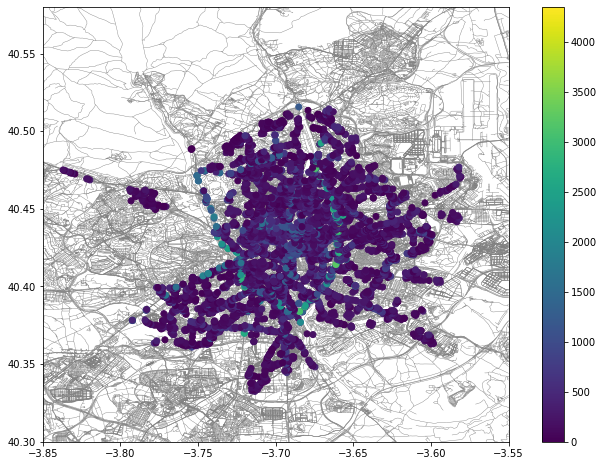

In [18]:
base = gdf_roads_clip.plot(figsize=(12, 8), color='grey', lw=0.4, zorder=0)  # Zorder controls the layering of the charts with
base.set_xlim(x_lim)
base.set_ylim(y_lim)
traffic_points_clip.plot(ax=base,column='x',legend=True)#, cmap='cool')

In [19]:
(poi_gdf['fclass'].unique())     #135

array(['hotel', 'cinema', 'ice_rink', 'restaurant', 'pub', 'theatre', 'police', 'supermarket', 'fast_food', 'pharmacy', 'bar', 'playground', 'camera_surveillance', 'cafe', 'bank', 'bookshop', 'memorial', 'artwork', 'bench', 'monument', 'university', 'toy_shop', 'clinic', 'drinking_water', 'bakery', 'kiosk',
       'post_box', 'post_office', 'florist', 'hairdresser', 'convenience', 'recycling_glass', 'butcher', 'veterinary', 'hostel', 'sports_centre', 'atm', 'doityourself', 'dentist', 'greengrocer', 'stationery', 'recycling', 'kindergarten', 'museum', 'nightclub', 'tourist_info', 'bicycle_rental', 'library',
       'recycling_paper', 'shoe_shop', 'toilet', 'ruins', 'gift_shop', 'viewpoint', 'attraction', 'telephone', 'comms_tower', 'pitch', 'fountain', 'school', 'college', 'park', 'embassy', 'market_place', 'swimming_pool', 'picnic_site', 'bicycle_shop', 'outdoor_shop', 'vending_parking', 'tower', 'garden_centre',
       'car_dealership', 'sports_shop', 'archaeological', 'water_tower', 

In [20]:
count_poi = pd.DataFrame(poi_gdf['fclass'].value_counts())
print(count_poi)

                     fclass
restaurant             5874
bench                  5325
drinking_water         2921
camera_surveillance    2716
pharmacy               2468
...                     ...
car_sharing               1
alpine_hut                1
ice_rink                  1
theme_park                1
vending_cigarette         1

[135 rows x 1 columns]


<AxesSubplot:>

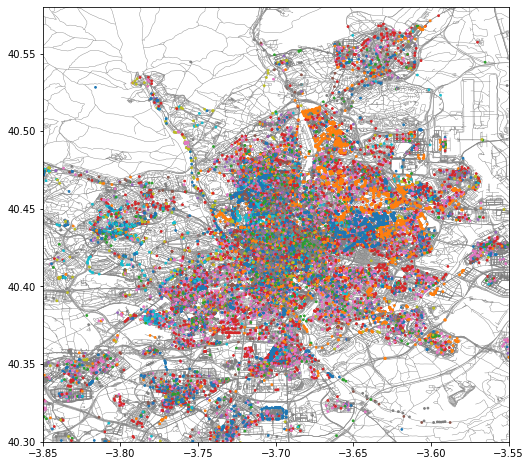

In [21]:
base = gdf_roads_clip.plot(figsize=(12, 8), color='grey', lw=0.4, zorder=0)  # Zorder controls the layering of the charts with
base.set_xlim(x_lim)
base.set_ylim(y_lim)
poi_gdf.plot(ax=base,markersize=3,column='fclass') #,color='red'

<AxesSubplot:>

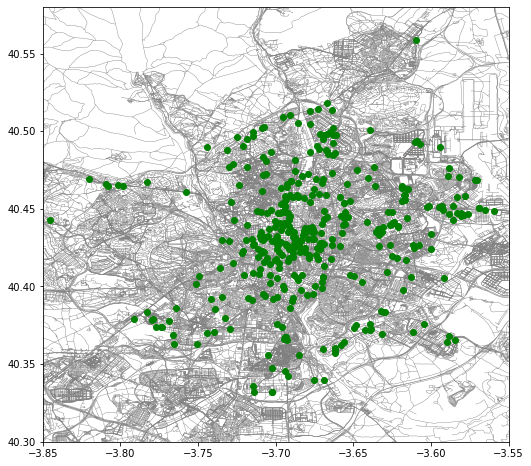

In [22]:
base = gdf_roads_clip.plot(figsize=(12, 8), color='grey', lw=0.4, zorder=0)  # Zorder controls the layering of the charts with
base.set_xlim(x_lim)
base.set_ylim(y_lim)
existing_chargers_gdf.plot(ax=base,color='green')

In [23]:
def exagon(r,y_lim,x_lim):
    xmin =x_lim[0]
    xmax =x_lim[1]
    ymin =y_lim[0]
    ymax =y_lim[1]

    # twice the height of a hexagon's equilateral triangle
    h = (r * math.sqrt(3))

    polygons = []
    tot_traffic_pre=[]
    tot_mixed=[]
    tot_chargers=[]
    tot_centroide_x=[]
    tot_centroide_y=[]
    colore=[]
    rows=0
    cols=0
    # create the hexagons
    for x in np.arange(xmin, xmax, h):
        k=1
        for y in np.arange(ymin, ymax, (h * h / r / 2)):
            if k==0:
                x=x+r * math.sqrt(3)/2
                hexagon = shape(
                    {
                        "type": "Polygon",
                        "coordinates": [
                            [
                                [x, y + r],
                                [x + h / 2, y + r / 2],
                                [x + h / 2, y - r / 2],
                                [x, y - r],
                                [x - h / 2, y - r / 2],
                                [x - h / 2, y + r / 2],
                                [x, y + r],
                            ]
                        ],
                    }
                )
                polygons.append(hexagon)
                centroide_x=x
                centroide_y=y
                x=x-r * math.sqrt(3)/2
                k=1
            elif k==1:
                hexagon = shape(
                    {
                        "type": "Polygon",
                        "coordinates": [
                            [
                                [x, y + r],
                                [x + h / 2, y + r / 2],
                                [x + h / 2, y - r / 2],
                                [x, y - r],
                                [x - h / 2, y - r / 2],
                                [x - h / 2, y + r / 2],
                                [x, y + r],
                            ]
                        ],
                    }
                )
                polygons.append(hexagon)
                k=0
                centroide_x=x
                centroide_y=y
            tot_centroide_x.append(centroide_x)
            tot_centroide_y.append(centroide_y)
            parziale=traffic_points_gdf.clip(hexagon)["x"].sum()
            tot_traffic_pre.append(parziale)
            #mixed=mean_car_count_gdf.clip(hexagon)["mixed_use_area_per_cell"].mean()
            #tot_mixed.append(mixed)
            chargers=existing_chargers_gdf.clip(hexagon)['longitud'].count()
            tot_chargers.append(chargers)
            rows+=1
        cols+=1   
    rows=int(rows/cols)
    tot_traffic = copy.copy(tot_traffic_pre)
    for i in range(len(tot_traffic)):
        if tot_traffic_pre[i]==0:
            v_n = neigh.neighbors(rows,cols,i)[0]
            tot_traffic[i] = np.mean([tot_traffic_pre[int(j)] for j in v_n])
    
    mas=max(tot_traffic)
    for k in range(len(tot_traffic)):
        if tot_traffic[k]<=0.0*mas:
            col='lightcyan'
        elif tot_traffic[k]<=0.15*mas:
            col='lightskyblue'
        elif tot_traffic[k]<=0.4*mas:
            col='deepskyblue'
        elif tot_traffic[k]<=0.6*mas:
            col='royalblue'
        elif tot_traffic[k]<=mas:
            col='darkblue'
        colore.append(col)
    with open('dati.csv', mode='w') as csv_file:
        csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        #scriviamo prima la riga di intestazione
        csv_writer.writerow(['ID', 'Traffico', 'no_existing_chg', 'centroid_x', 'centroid_y', 'Colore']) #,'mixed_use_area_per_cell'
        for k in range(len(tot_chargers)):
            csv_writer.writerow([k,tot_traffic[k],tot_chargers[k],tot_centroide_x[k],tot_centroide_y[k],colore[k]]) #,tot_mixed[k]
    #poly_grid = gpd.GeoDataFrame({'geometry': polygons}) 
    #base = gdf_roads_clip.plot(figsize=(12, 8), color='deepskyblue', lw=0.4, zorder=0)  # Zorder controls the layering of the charts with
    #base.set_xlim(x_lim)
    #base.set_ylim(y_lim)    
    #poly_grid.plot(ax=base, facecolor=colore, edgecolor='black', lw=0.5, zorder=15)
    #poly_grid.to_file(os.getcwd()+'\\shapefiles\\grid_exa.shp')
    return polygons,rows,cols,colore

In [24]:
#exagon grid
radius = 0.008
polygons,rows,cols,colore = exagon(radius,y_lim,x_lim)

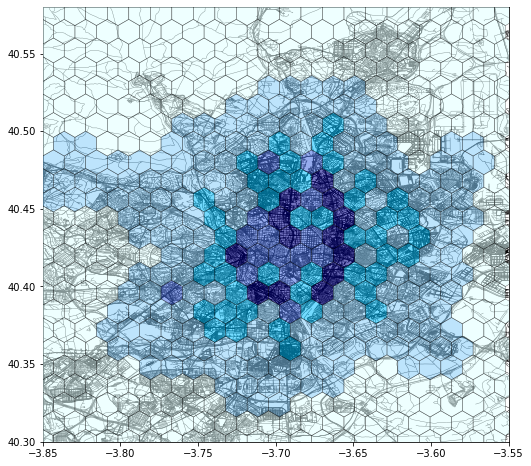

In [25]:
poly_grid = gpd.GeoDataFrame({'geometry': polygons}) 
base = gdf_roads_clip.plot(figsize=(12, 8), color='black', lw=0.4, zorder=0)  # Zorder controls the layering of the charts with
base.set_xlim(x_lim)
base.set_ylim(y_lim)    
poly_grid.plot(ax=base, facecolor=colore, edgecolor='black', lw=0.5, zorder=15,alpha=0.55)
#poly_grid.plot(ax=base, facecolor='#999999', edgecolor='black', lw=0.5, zorder=15)
poly_grid.to_file(os.getcwd()+'\\shapefiles\\grid_exa.shp')

In [26]:
traffic_points = gpd.read_file(os.getcwd()+'\\shapefiles\\traffic_points.shp')
polys = gpd.read_file(os.getcwd()+'\\shapefiles\\grid_exa.shp')
points_polys = gpd.sjoin(traffic_points, polys, how="right")

### Optimisation.py

In [27]:
# Import GIS data and car park location data
GIS_data = pd.read_csv(os.getcwd()+'\\dati.csv')
GIS_df = pd.DataFrame(GIS_data)
#GIS_df['mixed_use_area_per_cell']=GIS_df['mixed_use_area_per_cell'].fillna(0)

car_park_data = GIS_df.iloc[:,[0,3,4]]
car_park_df = pd.DataFrame(car_park_data)

In [28]:
def gen_sets(df_demand, df_parking):
    """Generate sets to use in the optimization problem"""
    # set of charging demand locations (destinations)
    demand_lc = df_demand.index.tolist()
    # set of candidates for charging station locations (currently existing parking lots)
    chg_lc = df_parking.index.tolist()
    return demand_lc, chg_lc

In [29]:
def gen_parameters(df_demand, df_parking):
    """Generate parameters to use in the optimization problem,
    including cost to install charging stations, operating costs and others..."""

    v0 = 0.05   # the charging possibility of an EV in cell i
    u = 0.10    # the EV penetration rate (utilisation rate) - 10 % of each day are used for charging
    pe = 0.17   # price of electricity per kWh (£/kWh)
    lj = 10     # maximum number of chargers in a station
    alpha = 52  # Average battery capacity (kWh)
    N = 10      # Total number of stations to be installed
    #r= 150      # "Radius" of the exagon
    
    #Ai = df_demand["mixed_use_area_per_cell"]  # Ai stands for sum of area of the mixed use parts in cell i
    #A = math.sqrt(3)*1.5*r*r             # A is the total area of cell i
    vi = v0 #Ai / A * v0                           # Where vi is the charging possibility of an EV in cell i
    fi = df_demand["Traffico"]          # Where fi is the average traffic flow in grid i
    di = u * vi * fi * 100000000                          # Where di represents the charging demand of EV in grid i
    di = di.to_dict()

    # Fast Chargers
    df_demand['m'] = 2                       # Number of charging sessions per day (session/day)
    m = df_demand['m'].to_dict()
    df_demand['p'] = 20 #!!!!!!!!!!!!!!!!!   # Cost of charging per minute (£/minute) (approx £6-7/30min)
    p = df_demand['p'].to_dict()
    df_demand['t'] = 240                     # Charging time for an EV (minutes)
    t = df_demand['t'].to_dict()
    df_demand['ci_j'] = 1000                 # Installation cost
    ci_j = df_demand['ci_j'].to_dict()
    df_demand['cr_j'] = 30                   # cr_j represents the parking fee per day of parking lot j
    cr_j = df_demand['cr_j'].to_dict()
    df_demand['ce_j'] = 1100                 # ce_j represents the price of a charger in station j
    ce_j = df_demand['ce_j'].to_dict()

    # distance matrix of charging station location candidates and charging demand location
    coords_parking = [(x, y) for x, y in zip(df_parking['centroid_x'], df_parking['centroid_y'])]

    coords_demand = [(x, y) for x, y in zip(df_demand['centroid_x'], df_demand['centroid_y'])]

    distance_matrix = distance.cdist(coords_parking, coords_demand, 'euclidean')
    scaling_ratio = 1
    distance_matrix2 = scaling_ratio * distance_matrix
    distance_matrix3 = pd.DataFrame(distance_matrix2, index=df_parking.index.tolist(),
                                    columns=df_demand.index.tolist())
                                    
    #poi_df = qge.read_shapefile(gp_poi)
    coords_pois = [(x, y) for x, y in zip(poi_df['longitud'], poi_df['latitud'])]
    distance_matrix_poi = distance.cdist(coords_parking, coords_pois, 'euclidean')
    distance_matrix_poi = pd.DataFrame(distance_matrix_poi, index=df_parking.index.tolist())
    distance_poi = distance_matrix_poi.sum()
    max = np.max(distance_poi)
    min = np.min(distance_poi)
    d_poi_scale = (distance_poi - min)/(max - min) 
    plt.hist(d_poi_scale)
    #plt.show()
    #print(distance_poi.head())
    return di, m, p, t, ci_j, cr_j, ce_j, pe, alpha, lj, N, distance_matrix3, d_poi_scale

In [30]:
def gen_demand(df_demand):
    """generate the current demand for charging for each cell i"""

    diz = df_demand["no_existing_chg"]  # Number of existing chargers in cell i
    diz = diz.to_dict()

    return diz

In [49]:
def optimize(df_demand, df_parking):

    # Import i and j set function
    demand_lc, chg_lc = gen_sets(df_demand, df_parking)

    # Import parameters function
    di, m, p, t, ci_j, cr_j, ce_j, pe, alpha, lj, N, distance_matrix, d_poi_scale = gen_parameters(df_demand, df_parking)

    # Import current demand of car park z in cell i
    diz = gen_demand(df_demand)

    # set up the optimization problem
    prob = LpProblem('FacilityLocation', LpMaximize)

    n = LpVariable.dicts("no_of_chgrs_station_j",
                         [j for j in chg_lc],
                         0, lj, LpInteger)
    q = LpVariable.dicts("Remaining_dem_station_j",
                         [j for j in chg_lc],
                         0)
    c = LpVariable.dicts("Tot_costs_station_j",
                         [j for j in chg_lc],
                         0)
    x = LpVariable.dicts("UseLocation", [j for j in chg_lc], 0, 1, LpBinary)

    r = np.full([len(demand_lc), len(chg_lc)], None)

    for i in demand_lc:
        for j in chg_lc:
            if distance_matrix[i][j] <= 500:
                r[i][j] = 1
            else:
                r[i][j] = 0
    count = np.count_nonzero(r == 1)
    #print("The number of potential connections with a distance less than 500m is:", count)

    # Objective function
    # The scaled distance from the POI is considered as a multiplication factor
    prob += lpSum((p[j] * t[j] * q[j] - c[j])*(1-d_poi_scale[j]) for j in chg_lc)

    # Create empty dictionary for the remaining demand in cell i
    zip_iterator = zip(demand_lc, [None]*len(demand_lc))
    dr = dict(zip_iterator)

    # For each cell i subtract the existing number of charging stations from the charging demands in cell i
    for i in demand_lc:
        for j in chg_lc:
            dr[i] = di[i] - diz[i] * m[j]
            if dr[i] < 0:       # Can't have negative demand therefore limit minimum demand to zero
                dr[i] = 0
    
    #print(dr)
    # Constraints
    for j in chg_lc:
        prob += c[j] == (cr_j[j] + ce_j[j] + ci_j[j] + 0.1 * ce_j[j] + 0.1 * ci_j[j]) * n[j] + pe * alpha * q[j]  
    for j in chg_lc:
        prob += q[j] - n[j] * m[j] <= 0                                 # Constraint 1
    for j in chg_lc:
        prob += q[j] - lpSum(r[i][j] * dr[i] for i in demand_lc) <= 0   # Constraint 2
    for i in chg_lc:
        prob += lpSum(x[j] * r[i][j] for j in chg_lc) - 1 <= 0          # Constraint 3
    for j in chg_lc:
        prob += n[j] - x[j] >= 0                                        # Constraint 4
    for j in chg_lc:
        prob += n[j] - lj * x[j] <= 0                                   # Constraint 5

    prob += lpSum(x[j] for j in chg_lc) == N                            # Constraint 6

    prob.solve()
    print("Status: ", LpStatus[prob.status])
    tolerance = .00001
    opt_location = []
    for j in chg_lc:
        if x[j].varValue > tolerance:   # If binary value x is positive then the car park has been selected
            opt_location.append(j)
            print("Establish charging station at parking lot", j)
    df_status = pd.DataFrame({"status": [LpStatus[prob.status]], "Tot_no_chargers": [len(opt_location)]})
    print("Final Optimisation Status:\n", df_status)

    print(prob.variables())
    varDic = {}
    for variable in prob.variables():
        var = variable.name
        if var[:5] == 'no_of':      # Filter to obtain only the variable 'no_of_chgrs_station_j'
            varDic[var] = variable.varValue

    print(varDic)
    for variable in prob.variables():
        var = variable.name
#         print(var)
#         print(variable.varValue)

    var_df = pd.DataFrame.from_dict(varDic, orient='index', columns=['value'])
    # Sort the results numerically
    sorted_df = var_df.index.to_series().str.rsplit('_').str[-1].astype(int).sort_values()
    var_df = var_df.reindex(index=sorted_df.index)
    var_df.reset_index(inplace=True)

    location_df = pd.DataFrame(opt_location, columns=['opt_car_park_id'])
#     print(location_df.head())
#     print(car_park_df.head())
    opt_loc_df = pd.merge(location_df, car_park_df, left_on='opt_car_park_id',  right_index=True, how='left')
    opt_loc_df2 = pd.merge(opt_loc_df, var_df, left_on='opt_car_park_id',  right_index=True, how='left')
#     opt_loc_df2.to_csv(path_or_buf='optimal_locations.csv')

    # Import the road shapefiles
    '''''
    shp_path_roads_1 = os.getcwd()+'\\shapefiles\\gis_osm_roads_free_1.shp'
    sf_roads_1 = shp.Reader(shp_path_roads_1)
    df_roads = read_shapefile(sf_roads_1)
    df_roads['coords'] = df_roads['coords'].apply(LineString)
    df_roads = gpd.GeoDataFrame(df_roads, geometry='coords')
    roads_df = df_roads #accrocco al volo

    base = roads_df.plot(figsize=(12, 8), color='grey', lw=0.4, zorder=0)
    plot = sns.scatterplot(ax=base, x=opt_loc_df['centroid_x'], y=opt_loc_df['centroid_y'], color='dodgerblue', legend='full')
    plot.set_xlim(x_lim[0], x_lim[1])
    plot.set_ylim(y_lim[0], y_lim[1])
    plot.set_title(f'Optimal locations for {len(opt_location)} chargers')

    for line in range(0, opt_loc_df2.shape[0]):
        plot.text(opt_loc_df2.centroid_x[line] + 50, opt_loc_df2.centroid_y[line],
                  opt_loc_df2.value[line], horizontalalignment='left',
                  size='medium', color='black', weight='semibold')
                  
#    print(opt_loc_df2)
    
    plt.show()
    '''''
    
    v1tot=[]
    v2tot=[]
    for i in opt_location:
        v=neigh.neighbors(rows,cols,i)
        v1tot = v1tot + v[0]
        v2tot = v2tot + v[1]

    v2tot = [int(x) for x in v2tot] 
    v1tot = [int(x) for x in v1tot] 
    opt_location = [int(x) for x in opt_location] 
    color = pd.DataFrame(['white']*len(df_parking)).transpose()
    color[v2tot] = 'yellow'
    color[v1tot] = 'orange'
    color[opt_location] = 'red'
    pol2=[polygons[i] for i in v2tot]
    poly_grid2 = gpd.GeoDataFrame({'geometry': pol2})
    poly_grid2.to_file(os.getcwd()+'\\shapefiles\\exa_2.shp')
    pol1=[polygons[i] for i in v1tot]
    poly_grid1 = gpd.GeoDataFrame({'geometry': pol1})
    poly_grid1.to_file(os.getcwd()+'\\shapefiles\\exa_1.shp')
    optpol=[polygons[i] for i in opt_location]
    poly_grid_opt = gpd.GeoDataFrame({'geometry': optpol})
    poly_grid_opt.to_file(os.getcwd()+'\\shapefiles\\exa_opt.shp')
    
    print('Done')
    return opt_location, df_status, opt_loc_df, opt_loc_df2, color


Status:  Infeasible
Establish charging station at parking lot 3
Establish charging station at parking lot 4
Establish charging station at parking lot 5
Establish charging station at parking lot 6
Establish charging station at parking lot 15
Establish charging station at parking lot 23
Establish charging station at parking lot 24
Establish charging station at parking lot 25
Establish charging station at parking lot 119
Establish charging station at parking lot 122
Final Optimisation Status:
        status  Tot_no_chargers
0  Infeasible               10
[Remaining_dem_station_j_0, Remaining_dem_station_j_1, Remaining_dem_station_j_10, Remaining_dem_station_j_100, Remaining_dem_station_j_101, Remaining_dem_station_j_102, Remaining_dem_station_j_103, Remaining_dem_station_j_104, Remaining_dem_station_j_105, Remaining_dem_station_j_106, Remaining_dem_station_j_107, Remaining_dem_station_j_108, Remaining_dem_station_j_109, Remaining_dem_station_j_11, Remaining_dem_station_j_110, Remaining_de

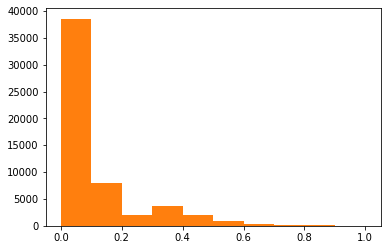

In [50]:
gen_sets(GIS_df,car_park_df)
gen_parameters(GIS_df,car_park_df)
gen_demand(GIS_df)
opt_loc, stat, opt_loc_df, opt_loc_df2, color_opt = optimize(GIS_df,car_park_df)

In [45]:
opt_loc_df2

,opt_car_park_id,ID,centroid_x,centroid_y,index,value
0,3,3,-3.843072,40.336,no_of_chgrs_station_j_3,10.0
1,4,4,-3.850000,40.348,no_of_chgrs_station_j_4,10.0
2,5,5,-3.843072,40.360,no_of_chgrs_station_j_5,10.0
3,6,6,-3.850000,40.372,no_of_chgrs_station_j_6,10.0
4,15,15,-3.843072,40.480,no_of_chgrs_station_j_15,10.0
5,23,23,-3.843072,40.576,no_of_chgrs_station_j_23,10.0
6,24,24,-3.836144,40.300,no_of_chgrs_station_j_24,10.0
7,25,25,-3.829215,40.312,no_of_chgrs_station_j_25,10.0
8,119,119,-3.787646,40.576,no_of_chgrs_station_j_119,10.0
9,122,122,-3.780718,40.324,no_of_chgrs_station_j_122,10.0


KeyboardInterrupt: 

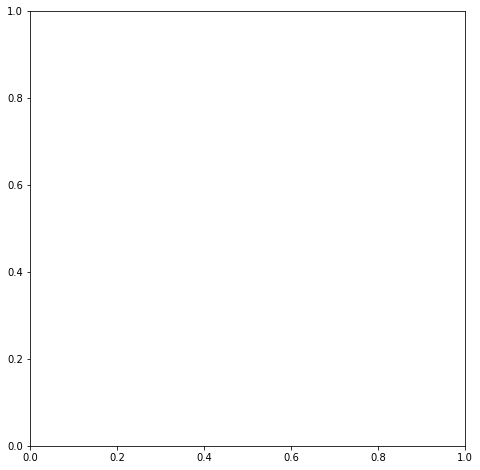

In [46]:
base = gdf_roads_clip.plot(figsize=(12, 8), color='grey', lw=0.4, zorder=0)
plot = sns.scatterplot(ax=base, x=opt_loc_df['centroid_x'], y=opt_loc_df['centroid_y'], color='mediumblue', legend='full')
plot.set_xlim(x_lim[0], x_lim[1])
plot.set_ylim(y_lim[0], y_lim[1])
plot.set_title(f'Optimal locations for {len(opt_loc)} chargers')

for line in range(opt_loc_df2.shape[0]):
    plot.text(opt_loc_df2.centroid_x[line], opt_loc_df2.centroid_y[line],
                opt_loc_df2.value[line], horizontalalignment='left',
                size='medium', color='black', weight='semibold')
plt.show()

In [ ]:
col_opt = (color_opt).values.tolist()[0]

<AxesSubplot:>

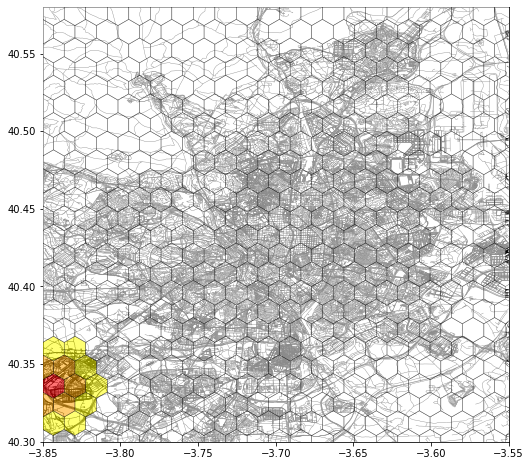

In [ ]:
base = gdf_roads_clip.plot(figsize=(12, 8), color='black', lw=0.4, zorder=0)  # Zorder controls the layering of the charts with
base.set_xlim(x_lim)
base.set_ylim(y_lim)    
poly_grid.plot(ax=base, facecolor=col_opt, edgecolor='black', lw=0.5, zorder=15,alpha=0.55)

In [ ]:
opt_locations=car_park_df.iloc[opt_loc]
print(opt_locations[['centroid_x', 'centroid_y']])

def point_df_to_gdf2(df):
    """takes a dataframe with columns named 'longitude' and 'latitude'
    to transform to a geodataframe with point features"""

    df['coordinates'] = df[['centroid_x', 'centroid_y']].values.tolist()
    df['coordinates'] = df['coordinates'].apply(Point)
    df = gpd.GeoDataFrame(df, geometry='coordinates')
    return df
    
    
opt_loc_gdf = point_df_to_gdf2(opt_locations)
opt_loc_gdf.to_file(os.getcwd()+'\\shapefiles\\opt_loc_exa.shp')

   centroid_x  centroid_y
3   -3.843072      40.336


C:\Users\User\AppData\Local\Temp\ipykernel_13940\4087890322.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['coordinates'] = df[['centroid_x', 'centroid_y']].values.tolist()
C:\Users\User\AppData\Local\Temp\ipykernel_13940\4087890322.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['coordinates'] = df['coordinates'].apply(Point)
C:\Users\User\AppData\Local\Temp\ipykernel_13940\4087890322.py:15: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
 